## Colaborative filtering

Problem: You have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. For example: recommending movies (such as Netflix).

General solution: it's called collaborative filtering - look at what products the current user has used or liked, find other users that have used or liked similar products, and the recommend other products that those users have used or liked.

## Movie recommendation

We are going to work on this movie recommendation problem.

In [1]:
import numpy as np
import pandas as pd
import torch
from fastai.collab import (
    collab_learner,
    get_emb_sz,
    one_hot,
    set_seed,
    sigmoid_range,
    tensor,
    CollabDataLoaders,
    L,
)

from fastai.tabular.all import (
    untar_data,
    Learner,
    MSELossFlat,
    URLs
)

set_seed(42)

**Dataset**

[MovieLens](https://grouplens.org/datasets/movielens/)

This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although we will just use a subset of 100,000 of them for our example.

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(
    path / "u.data",
    delimiter="\t",
    header=None,
    names=["user","movie", "rating", "timestamp"]
)
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


from matplotlib import pyplot as plt
_df_0['user'].plot(kind='hist', bins=20, title='user')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['movie'].plot(kind='hist', bins=20, title='movie')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='user', y='movie', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='movie', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='rating', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['user']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('user')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['movie']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('movie')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['user'].plot(kind='line', figsize=(8, 4), title='user')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['movie'].plot(kind='line', figsize=(8, 4), title='movie')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

Here is the same data cross-tabulated into a human-friendly table as example (where we have selected just a few of the most popular movies, and users who watch the most movies).


![](images/friendly_table.png)


The empty cells in this table are the things that we would like our model to learn to fill in.

If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and user a combination.

For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie `The Last Skywalker` as:

In [4]:
last_skywalker = np.array([0.98, 0.9, -0.9])
# preferences of user1 for each category

user1 = np.array([0.9, 0.8, -0.6])

# calculate the match between this combination:
(user1 * last_skywalker).sum()

2.1420000000000003

Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them.

Latent factors in collaborative filtering are inferred attributes that help explain the ratings and preferences of users in terms of unobserved characteristics of items.

### Learning the latent factors

**Step 1**

Randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. We will have to decide how many to use, for now, we will say that 5.

![](images/initialization.png)


**Step 2**

Calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user.


**Step 3**

Calculate our loss. We can use any loss function that we wish; let's pick mean squared error for now.



With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss.

At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate.

After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

### Creating the data loaders

When showing the data, we would rather see movie titles than their IDs. The table u.item contains the correspondence of IDs to titles.

In [5]:
movies = pd.read_csv(
    path / "u.item",
    delimiter="|",
    encoding="latin-1",
    usecols=(0, 1),
    names=("movie", "title"),
    header=None
)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
# We can merge this with our ratings table to get the user ratings by title:

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can then build a DataLoaders object from this table. By default, it takes the first column for the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of item_name in our case to use the titles instead of the IDs:

In [7]:
batch_size = 64

dls = CollabDataLoaders.from_df(ratings, item_name="title", bs=batch_size)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework.

In [8]:
n_users  = len(dls.classes["user"])
n_movies = len(dls.classes["title"])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors.


It turns out that we can represent look up in an index as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index #3:

In [9]:
idx = 3

one_hot_3 = one_hot(idx, n_users).float()

one_hot_3[:7] # only have a 1 at 3rd index

tensor([0., 0., 0., 1., 0., 0., 0.])

In [10]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [11]:
# It gives us the same vector as the one at index 3 in the matrix:

user_factors[idx]


tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary.

We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one. We should just be able to index into an array directly with an integer.


Therefore, DL libraries like PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

**Embedding**: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the _embedding matrix_.

### Collaborative filtering from scratch

In [12]:
from torch.nn import Embedding, Module, Parameter

In [13]:
class DotProduct(Module):
    def __init__(self, n_users: int, n_movies: int, n_factors: int):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x: torch.Tensor):
        """Perform dot product given the users' ids and movies' ids"""
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])

        return (users * movies).sum(dim=1)

In [14]:
x,y = dls.one_batch()

x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [17]:
# we need to create a Learner to optimize our model
num_factors = 50

model = DotProduct(n_users, n_movies, num_factors)
learner = Learner(dls, model, loss_func=MSELossFlat())

In [18]:
epochs = 8
lr = 5e-3

learner.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,time
0,53.277718,52.764614,00:09
1,28.894283,29.877609,00:08
2,8.986207,12.488729,00:08
3,3.038282,5.800101,00:07
4,1.513173,4.063973,00:08
5,0.976256,3.471833,00:08
6,0.717574,3.299766,00:07
7,0.591596,3.276249,00:08


Force the predictions to be between 0 and 5, empirically we know that is better to have an offset after 5, so 5.5.

In [19]:
class DotProduct(Module):
    def __init__(self, n_users: int, n_movies: int, n_factors: int, y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x: torch.Tensor):
        """Perform dot product given the users' ids and movies' ids"""
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        y = (users * movies).sum(dim=1)

        return sigmoid_range(y, *self.y_range)

In [20]:
model = DotProduct(n_users, n_movies, num_factors)
learner = Learner(dls, model, loss_func=MSELossFlat())

learner.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,time
0,7.692507,7.572563,00:08
1,7.120202,7.307688,00:08
2,5.844981,6.892922,00:07
3,4.813981,6.366472,00:08
4,3.942397,5.796530,00:08
5,3.076184,5.402319,00:08
6,2.688584,5.223583,00:08
7,2.415312,5.196467,00:08


One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things.

BIAS!!!

At this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and also for each movie, that will handle this missing piece very nicely.

In [21]:
class DotProduct(Module):
    def __init__(self, n_users: int, n_movies: int, n_factors: int, y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)

        self.y_range = y_range

    def forward(self, x: torch.Tensor):
        """Perform dot product given the users' ids and movies' ids"""
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        y = (users * movies).sum(dim=1, keepdim=True)
        y += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])

        return sigmoid_range(y, *self.y_range)

In [22]:
model = DotProduct(n_users, n_movies, num_factors)
learner = Learner(dls, model, loss_func=MSELossFlat())

learner.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,time
0,7.662781,7.535754,00:08
1,6.714587,6.778738,00:08
2,5.262075,5.921647,00:08
3,4.036416,5.185709,00:08
4,3.094340,4.687833,00:08
5,2.515245,4.387840,00:08
6,2.186666,4.268723,00:08
7,2.005899,4.250600,00:08


#### Weight Decay

We are getting worse, because overfitting, we need some kind of generalization, in this case weight decay.


Weight decay, or **L2 regularization*+, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.


Example:
```python
loss_with_wd = loss + wd * (parameters**2).sum()


# we could do better if we sum the result to gradients, because the square of the sum could be inneficient.

parameters.grad += wd * 2 * parameters

# because wd is a control, so we can ommit the '2' of the derivative.

parameters.grad += wd * parameters
```


In [23]:
# the way to do it in fast.ai is passing wd param
WEIGHT_DECAY = 0.1

model = DotProduct(n_users, n_movies, num_factors)
learner = Learner(dls, model, loss_func=MSELossFlat())

learner.fit_one_cycle(epochs, lr, wd=WEIGHT_DECAY)

epoch,train_loss,valid_loss,time
0,7.286504,7.237398,00:08
1,3.449600,3.311263,00:08
2,1.050767,1.120833,00:08
3,0.760724,0.934134,00:09
4,0.622387,0.897798,00:08
5,0.482976,0.892179,00:09
6,0.412291,0.895385,00:08
7,0.338864,0.895818,00:08


#### Creating Our Own Embedding Module

Optimizers require that they can get all the parameters of a module from the module's parameters method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in parameters.

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` (calling `requires_grad_` for us automatically).

In [25]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.a = Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

We can create a tensor as a parameter, with random initialization, like so:

In [26]:
def create_params(size):
    return Parameter(torch.zeros(*size).normal_(0, 0.01))

In [33]:
class DotProduct(Module):
    def __init__(self, n_users: int, n_movies: int, n_factors: int, y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users, 1])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies, 1])

        self.y_range = y_range

    def forward(self, x: torch.Tensor):
        """Perform dot product given the users' ids and movies' ids"""
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        y = (users * movies).sum(dim=1, keepdim=True)
        y += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]

        return sigmoid_range(y, *self.y_range)

In [34]:
model = DotProduct(n_users, n_movies, num_factors)
learner = Learner(dls, model, loss_func=MSELossFlat())

learner.fit_one_cycle(epochs, lr, wd=WEIGHT_DECAY)

epoch,train_loss,valid_loss,time
0,0.998870,0.974608,00:09
1,0.865683,0.907756,00:09
2,0.808790,0.854293,00:08
3,0.676553,0.841560,00:09
4,0.572696,0.839028,00:09
5,0.455464,0.838895,00:09
6,0.358869,0.843700,00:08
7,0.312968,0.844275,00:09


### Interpreting Embeddings and Biases

Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered.

In [35]:
# Here are the movies with the lowest values in the bias vector, what the people don't enjoy watching it

movie_bias = learner.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes["title"][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Home Alone 3 (1997)',
 'Kansas City (1996)']

In [36]:
# the most liked movies

idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes["title"][i] for i in idxs]

['L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying directions in such a matrix, called principal component analysis (PCA). Here's what our movies look like based on two of the strongest PCA components.

In [37]:
import matplotlib.pyplot as plt

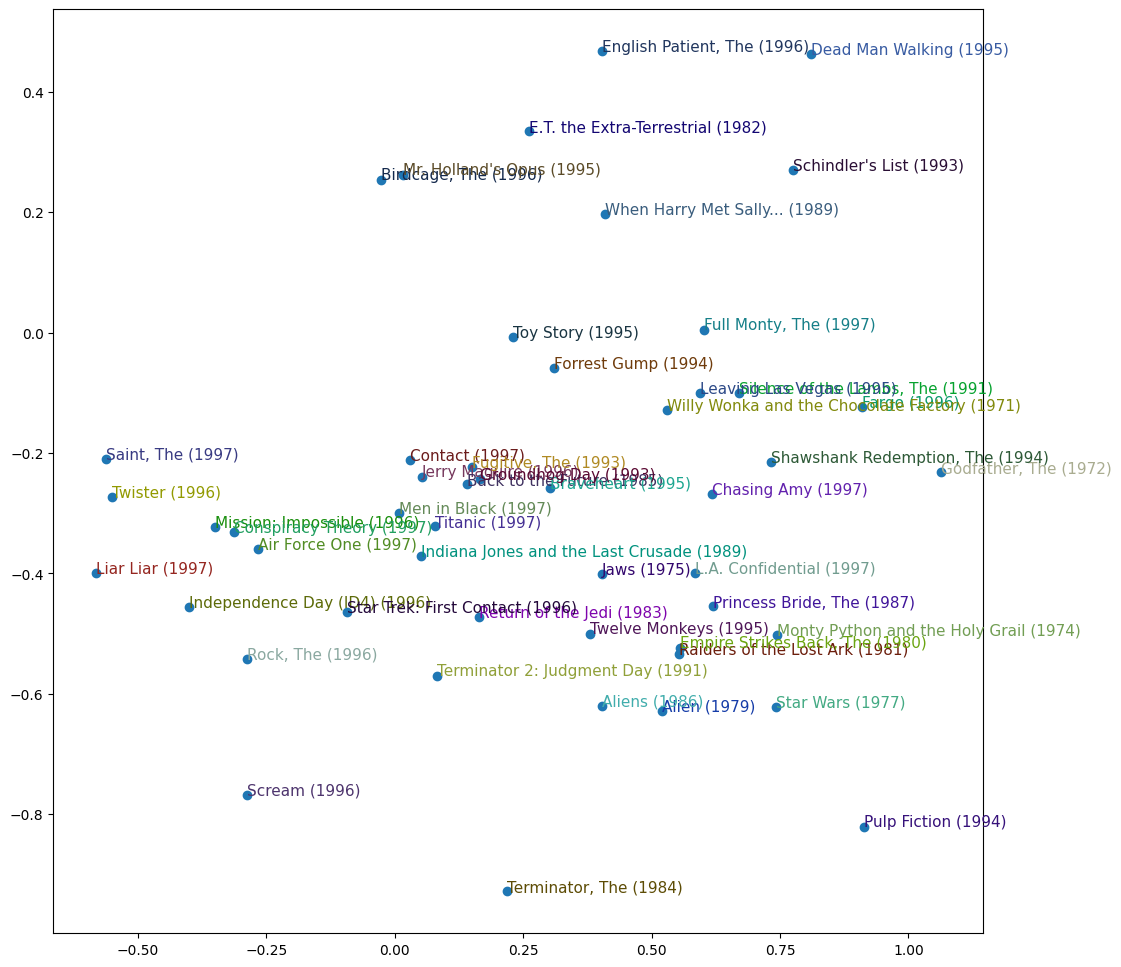

In [38]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learner.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learner.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of classic versus pop culture movie

#### Using fastai.collab


We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's collab_learner:

In [39]:
learner = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [40]:
learner.fit_one_cycle(epochs, lr, wd=WEIGHT_DECAY)

epoch,train_loss,valid_loss,time
0,1.006953,0.973631,00:08
1,0.894784,0.907375,00:08
2,0.795743,0.858048,00:08
3,0.677948,0.846873,00:08
4,0.567338,0.842889,00:08
5,0.467147,0.844884,00:09
6,0.370275,0.849145,00:09
7,0.323990,0.850142,00:08


In [41]:
# looking at the layers
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [42]:
# checking again the most liked movies, the results should be consistent with previous model

movie_bias = learner.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes["title"][i] for i in idxs]

["Schindler's List (1993)",
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'L.A. Confidential (1997)']

#### Embedding distance


If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same.


There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity.

In [44]:
movie_factors = learner.model.i_weight.weight

idx = dls.classes["title"].o2i["Titanic (1997)"]
distances = torch.nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
# the the vector with minimum distance
idx = distances.argsort(descending=True)[1]
dls.classes["title"][idx]

'Jerry Maguire (1996)'

How can we make recommendations to new users?

### Bootstrapping a Collaborative Filtering Model

The biggest challenge with using collaborative filtering models in practice is the bootstrapping problem. The most extreme version of this problem is when you have no users, and therefore no history to learn from.

You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent average taste.

Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector (Y), and the independent variables are the results of the questions that you ask them (X), along with their signup metadata.

**Possible issues with this approach (biases)**

If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially.

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data.

### Deep Learning for Collaborative Filtering

The approach that we revised before is called Probabilistic Matrix Factorization (PMF). We can achieve the same with deep neural networks.

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through a forward "prediction".

Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices can have different sizes (different numbers of latent factors). fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:

In [45]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [48]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), activations=100):
        super().__init__()
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(user_sz[1] + item_sz[1], activations),
            torch.nn.ReLU(),
            torch.nn.Linear(activations, 1)
        )
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))

        return sigmoid_range(x, *self.y_range)

In [49]:
model = CollabNN(*embs)

In [50]:
learner = Learner(dls, model, loss_func=MSELossFlat())
learner.fit_one_cycle(epochs, lr, wd=WEIGHT_DECAY)

epoch,train_loss,valid_loss,time
0,1.032681,1.016623,00:09
1,0.914757,0.940090,00:09
2,0.879491,0.925685,00:09
3,0.874991,0.899461,00:09
4,0.817902,0.872738,00:09
5,0.754956,0.866069,00:09
6,0.664263,0.876590,00:10
7,0.602007,0.884132,00:09


In [51]:
# fast.ai actually has the same model when passing use_nn flag, and let us create more hidden layers

learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100, 50])
learn.fit_one_cycle(epochs, lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.974145,0.996811,00:10
1,0.952520,0.933588,00:11
2,0.907762,0.916204,00:10
3,0.871856,0.876752,00:10
4,0.855447,0.857219,00:10
5,0.809427,0.852248,00:11
6,0.735181,0.858787,00:10
7,0.698382,0.873601,00:10


### Conclusion

We looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data.